# Project : Image classification and regression

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.patches as patches

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Input, UpSampling2D, Cropping2D, concatenate, ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.callbacks import History

Using TensorFlow backend.


# 1. Getting started

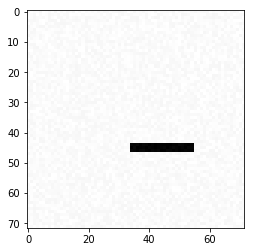

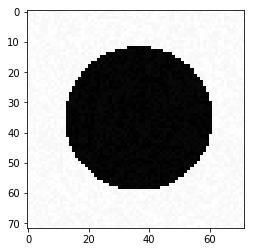

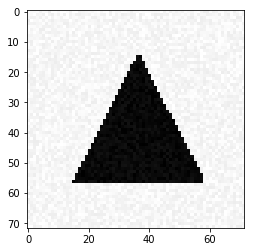

In [2]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = keras.utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]




# 2. Simple classification

In [3]:
X_train, Y_train = generate_dataset_classification(300, 20)
X_test, Y_test = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


# 2.1. Linear classifier SGD

Train on 300 samples, validate on 300 samples
Epoch 1/100
300/300 [==============================] - 0s 863us/step - loss: 1.1857 - acc: 0.4433 - val_loss: 1.0097 - val_acc: 0.4433
Epoch 2/100
300/300 [==============================] - 0s 152us/step - loss: 0.9701 - acc: 0.5267 - val_loss: 0.9241 - val_acc: 0.5333
Epoch 3/100
300/300 [==============================] - 0s 149us/step - loss: 0.9384 - acc: 0.5367 - val_loss: 0.8994 - val_acc: 0.7333
Epoch 4/100
300/300 [==============================] - 0s 130us/step - loss: 0.8570 - acc: 0.6633 - val_loss: 0.8414 - val_acc: 0.6867
Epoch 5/100
300/300 [==============================] - 0s 152us/step - loss: 0.7957 - acc: 0.6500 - val_loss: 0.7821 - val_acc: 0.6600
Epoch 6/100
300/300 [==============================] - 0s 144us/step - loss: 0.7711 - acc: 0.6700 - val_loss: 0.7743 - val_acc: 0.6000
Epoch 7/100
300/300 [==============================] - 0s 135us/step - loss: 0.7722 - acc: 0.6600 - val_loss: 0.7299 - val_acc: 0.7267
Epoch 8/1

300/300 [==============================] - 0s 176us/step - loss: 0.2599 - acc: 0.9733 - val_loss: 0.2715 - val_acc: 0.9633
Epoch 62/100
300/300 [==============================] - 0s 129us/step - loss: 0.2584 - acc: 0.9700 - val_loss: 0.3001 - val_acc: 0.8833
Epoch 63/100
300/300 [==============================] - 0s 157us/step - loss: 0.2675 - acc: 0.9667 - val_loss: 0.2637 - val_acc: 0.9900
Epoch 64/100
300/300 [==============================] - 0s 105us/step - loss: 0.2507 - acc: 0.9767 - val_loss: 0.2745 - val_acc: 0.9167
Epoch 65/100
300/300 [==============================] - 0s 124us/step - loss: 0.2545 - acc: 0.9667 - val_loss: 0.2548 - val_acc: 0.9867
Epoch 66/100
300/300 [==============================] - 0s 124us/step - loss: 0.2456 - acc: 0.9900 - val_loss: 0.2750 - val_acc: 0.9100
Epoch 67/100
300/300 [==============================] - 0s 125us/step - loss: 0.2501 - acc: 0.9733 - val_loss: 0.2539 - val_acc: 0.9700
Epoch 68/100
300/300 [==============================] - 0s 13

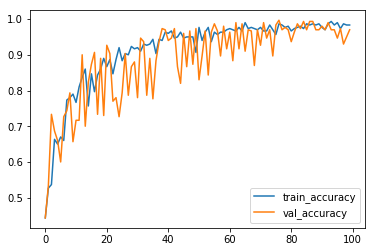

In [4]:
#Initial Parameters 
lr = 0.001
epochs = 100
batch_size = 32

from keras.utils import to_categorical
#Les Callbacks
history = History()
new_train = keras.utils.to_categorical(Y_train)
new_test = keras.utils.to_categorical(Y_test)


# SGD implementation
Lmodel = Sequential()
Lmodel.add(Dense(new_train.shape[1] , input_shape = (X_train.shape[1],) ))
Lmodel.add(Activation('softmax'))

optimizer = keras.optimizers.SGD(lr = lr)

Lmodel.compile(loss='categorical_crossentropy', optimizer= optimizer , metrics = ['accuracy'])
Lmodel.fit(X_train, new_train, epochs= epochs, validation_data = [X_test , new_test],
          batch_size=batch_size, callbacks = [history])

plt.plot(history.history['acc'] , label = 'train_accuracy')
plt.plot(history.history['val_acc'] , label= 'val_accuracy')
plt.legend()
plt.show()

# 2.2. Linear classifier Adam

Train on 300 samples, validate on 300 samples
Epoch 1/100
300/300 [==============================] - 0s 615us/step - loss: 1.0080 - acc: 0.5000 - val_loss: 0.9364 - val_acc: 0.6033
Epoch 2/100
300/300 [==============================] - 0s 117us/step - loss: 0.8973 - acc: 0.6800 - val_loss: 0.8515 - val_acc: 0.7100
Epoch 3/100
300/300 [==============================] - 0s 156us/step - loss: 0.8165 - acc: 0.7667 - val_loss: 0.7751 - val_acc: 0.7533
Epoch 4/100
300/300 [==============================] - 0s 129us/step - loss: 0.7480 - acc: 0.7667 - val_loss: 0.7194 - val_acc: 0.7533
Epoch 5/100
300/300 [==============================] - 0s 154us/step - loss: 0.6956 - acc: 0.7767 - val_loss: 0.6603 - val_acc: 0.8533
Epoch 6/100
300/300 [==============================] - 0s 168us/step - loss: 0.6500 - acc: 0.8100 - val_loss: 0.6186 - val_acc: 0.9000
Epoch 7/100
300/300 [==============================] - 0s 135us/step - loss: 0.6097 - acc: 0.8400 - val_loss: 0.6055 - val_acc: 0.7100
Epoch 8/1

Epoch 61/100
300/300 [==============================] - 0s 99us/step - loss: 0.1466 - acc: 1.0000 - val_loss: 0.1581 - val_acc: 0.9967
Epoch 62/100
300/300 [==============================] - 0s 130us/step - loss: 0.1469 - acc: 1.0000 - val_loss: 0.1533 - val_acc: 1.0000
Epoch 63/100
300/300 [==============================] - 0s 127us/step - loss: 0.1422 - acc: 1.0000 - val_loss: 0.1509 - val_acc: 1.0000
Epoch 64/100
300/300 [==============================] - 0s 151us/step - loss: 0.1398 - acc: 1.0000 - val_loss: 0.1495 - val_acc: 0.9967
Epoch 65/100
300/300 [==============================] - 0s 107us/step - loss: 0.1378 - acc: 1.0000 - val_loss: 0.1492 - val_acc: 1.0000
Epoch 66/100
300/300 [==============================] - 0s 121us/step - loss: 0.1387 - acc: 1.0000 - val_loss: 0.1535 - val_acc: 0.9900
Epoch 67/100
300/300 [==============================] - 0s 158us/step - loss: 0.1359 - acc: 0.9967 - val_loss: 0.1437 - val_acc: 1.0000
Epoch 68/100
300/300 [===========================

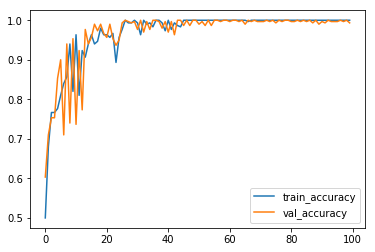

In [5]:
# Initial Parameters
lr = 0.0001
epochs = 100
history = History()

# Adam implementation
Amodel = Sequential()
Amodel.add(Dense(new_train.shape[1] , input_shape = (X_train.shape[1],) ))
Amodel.add(Activation('softmax'))

optimizer = keras.optimizers.Adam(lr = lr)

Amodel.compile(loss='categorical_crossentropy', optimizer= optimizer , metrics = ['accuracy'])
Amodel.fit(X_train, new_train, epochs= epochs, validation_data = [X_test , new_test],
          batch_size=batch_size, callbacks = [history])

plt.plot(history.history['acc'] , label = 'train_accuracy')
plt.plot(history.history['val_acc'] , label= 'val_accuracy')
plt.legend()
plt.show()

#  3. Visualisation of the solution

We will visualize the 3 columns of the matrix of the classifier as images

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


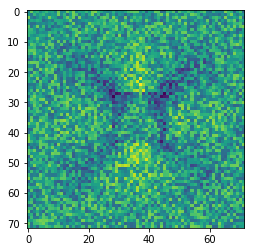

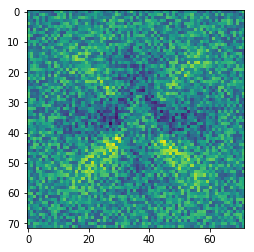

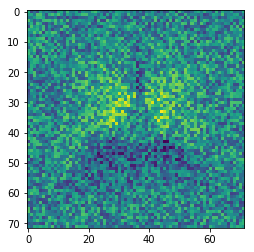

In [6]:
%pylab inline
weights = Amodel.get_weights()[0].T

for column in weights:
    plt.imshow(column.reshape((72 , 72)))
    plt.show()

# 4. A more difficult classification problem

We will generate 

In [8]:
X_train, Y_train = generate_dataset_classification(300, 200, True)
X_test, Y_test = generate_test_set_classification()

new_train = keras.utils.to_categorical(Y_train)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


# 4.1 Adam on the new training set

Train on 300 samples, validate on 300 samples
Epoch 1/100
300/300 [==============================] - 0s 667us/step - loss: 1.1272 - acc: 0.3367 - val_loss: 1.1315 - val_acc: 0.3367
Epoch 2/100
300/300 [==============================] - 0s 145us/step - loss: 1.0925 - acc: 0.3933 - val_loss: 1.1350 - val_acc: 0.3200
Epoch 3/100
300/300 [==============================] - 0s 189us/step - loss: 1.1003 - acc: 0.3467 - val_loss: 1.1157 - val_acc: 0.3500
Epoch 4/100
300/300 [==============================] - 0s 115us/step - loss: 1.0861 - acc: 0.3933 - val_loss: 1.1748 - val_acc: 0.3200
Epoch 5/100
300/300 [==============================] - 0s 154us/step - loss: 1.0961 - acc: 0.4567 - val_loss: 1.1206 - val_acc: 0.3300
Epoch 6/100
300/300 [==============================] - 0s 150us/step - loss: 1.0638 - acc: 0.4700 - val_loss: 1.1445 - val_acc: 0.3267
Epoch 7/100
300/300 [==============================] - 0s 164us/step - loss: 1.0548 - acc: 0.4533 - val_loss: 1.1204 - val_acc: 0.3267
Epoch 8/1

Epoch 61/100
300/300 [==============================] - 0s 174us/step - loss: 0.8642 - acc: 0.6600 - val_loss: 1.4076 - val_acc: 0.3433
Epoch 62/100
300/300 [==============================] - 0s 106us/step - loss: 0.8547 - acc: 0.6833 - val_loss: 1.4070 - val_acc: 0.3300
Epoch 63/100
300/300 [==============================] - 0s 134us/step - loss: 0.8532 - acc: 0.6900 - val_loss: 1.3975 - val_acc: 0.3533
Epoch 64/100
300/300 [==============================] - 0s 140us/step - loss: 0.8478 - acc: 0.6467 - val_loss: 1.4482 - val_acc: 0.3433
Epoch 65/100
300/300 [==============================] - 0s 129us/step - loss: 0.8484 - acc: 0.6400 - val_loss: 1.4458 - val_acc: 0.3300
Epoch 66/100
300/300 [==============================] - 0s 134us/step - loss: 0.8506 - acc: 0.6567 - val_loss: 1.4093 - val_acc: 0.3500
Epoch 67/100
300/300 [==============================] - 0s 182us/step - loss: 0.8452 - acc: 0.6400 - val_loss: 1.4746 - val_acc: 0.3367
Epoch 68/100
300/300 [==========================

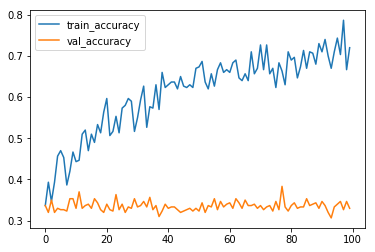

In [9]:
# Initial Parameters
lr = 0.0001
epochs = 100
history = History()

# Adam implementation
Amodel = Sequential()
Amodel.add(Dense(new_train.shape[1] , input_shape = (X_train.shape[1],) ))
Amodel.add(Activation('softmax'))

optimizer = keras.optimizers.Adam(lr = lr)

Amodel.compile(loss='categorical_crossentropy', optimizer= optimizer , metrics = ['accuracy'])
Amodel.fit(X_train, new_train, epochs= epochs, validation_data = [X_test , new_test],batch_size=batch_size, callbacks = [history])

plt.plot(history.history['acc'] , label = 'train_accuracy')
plt.plot(history.history['val_acc'] , label= 'val_accuracy')
plt.legend()
plt.show()

The value of the function loss on the data set is: 

# 4.2 Convolutional (not-to-) deep network 

Train on 300 samples, validate on 300 samples
Epoch 1/100
300/300 [==============================] - 2s 5ms/step - loss: 1.1207 - acc: 0.2967 - val_loss: 1.1046 - val_acc: 0.3300
Epoch 2/100
300/300 [==============================] - 1s 4ms/step - loss: 1.1019 - acc: 0.3933 - val_loss: 1.0701 - val_acc: 0.3700
Epoch 3/100
300/300 [==============================] - 1s 4ms/step - loss: 1.0996 - acc: 0.3633 - val_loss: 1.0706 - val_acc: 0.3300
Epoch 4/100
300/300 [==============================] - 1s 5ms/step - loss: 1.0718 - acc: 0.3767 - val_loss: 1.0235 - val_acc: 0.5700
Epoch 5/100
300/300 [==============================] - 1s 4ms/step - loss: 1.0602 - acc: 0.3733 - val_loss: 1.0042 - val_acc: 0.5800
Epoch 6/100
300/300 [==============================] - 1s 4ms/step - loss: 1.0407 - acc: 0.5500 - val_loss: 0.9799 - val_acc: 0.6200
Epoch 7/100
300/300 [==============================] - 1s 5ms/step - loss: 1.0111 - acc: 0.5600 - val_loss: 0.9715 - val_acc: 0.5733
Epoch 8/100
300/300 [==

Epoch 62/100
300/300 [==============================] - 1s 5ms/step - loss: 0.4079 - acc: 0.9833 - val_loss: 0.7650 - val_acc: 0.6467
Epoch 63/100
300/300 [==============================] - 1s 5ms/step - loss: 0.3979 - acc: 0.9833 - val_loss: 0.7891 - val_acc: 0.6133
Epoch 64/100
300/300 [==============================] - 1s 4ms/step - loss: 0.3892 - acc: 0.9900 - val_loss: 0.7737 - val_acc: 0.6467
Epoch 65/100
300/300 [==============================] - 1s 5ms/step - loss: 0.3862 - acc: 0.9767 - val_loss: 0.8172 - val_acc: 0.6067
Epoch 66/100
300/300 [==============================] - 1s 5ms/step - loss: 0.3793 - acc: 0.9900 - val_loss: 0.8217 - val_acc: 0.6033
Epoch 67/100
300/300 [==============================] - 1s 5ms/step - loss: 0.3749 - acc: 0.9700 - val_loss: 0.7819 - val_acc: 0.6200
Epoch 68/100
300/300 [==============================] - 1s 5ms/step - loss: 0.3619 - acc: 0.9800 - val_loss: 0.8082 - val_acc: 0.6433
Epoch 69/100
300/300 [==============================] - 1s 5ms

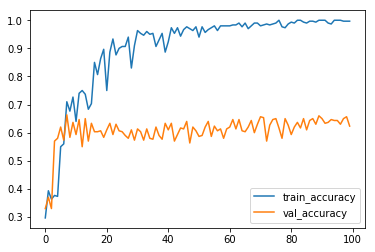

In [10]:
mX_train = X_train.reshape((300 , 72 , 72 , 1))
mX_test = X_test.reshape((300 , 72 , 72 , 1))

# Initial Parameters:
lr = 0.0001
epochs = 100
history = History()

# Convolutional deep network implementation
Cmodel = Sequential()
Cmodel.add(Conv2D(16 , 5 , input_shape = (72 , 72 , 1) , data_format="channels_last" ))
Cmodel.add(Activation('relu'))
Cmodel.add(MaxPooling2D(strides = 1))
Cmodel.add(Flatten())
Cmodel.add(Dense(new_train.shape[1]) )
Cmodel.add(Activation('softmax'))

optimizer = keras.optimizers.Adam(lr = lr)

Cmodel.compile(loss='categorical_crossentropy', optimizer= optimizer , metrics = ['accuracy'])
Cmodel.fit(mX_train, new_train, validation_data = [mX_test, Y_test] ,epochs= epochs, batch_size=batch_size, callbacks = [history])

plt.plot(history.history['acc'] , label = 'train_accuracy')
plt.plot(history.history['val_acc'] , label= 'val_accuracy')
plt.legend()
plt.show()

The value of the function loss on the data set is: 

# 5. Regression logistique

In [11]:
import tensorflow 

In [12]:
%%capture
def sort(T):
    Tsorted=[]
    for i in range(T.shape[0]):
        Vert=T[i,:]
        Svert = sorted(zip(Vert[[i*2 for i in range(3)]] , Vert[[i*2 + 1 for i in range(3)]]))
        Tsorted.append(np.array(Svert).flatten())
    return Tsorted
[X_train, Y_train] = generate_dataset_regression(300, 20)
Y_train = sort(Y_train)
X_test, Y_test = generate_test_set_regression()
Y_test = sort(Y_test)


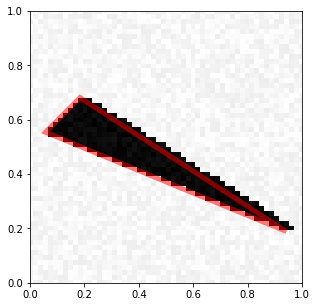

In [13]:
visualize_prediction(X_train[0], Y_train[0])